In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [13]:
image_path = os.getcwd() + "\\flipkart\\images\\"

In [14]:
df = pd.read_csv("flipkart\\flipkart_com-ecommerce_sample_1050.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [15]:
df["main_category"] = df['product_category_tree'].str.split(" >> ").str[0].str.replace('["', '')
df['main_category'].value_counts()

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [16]:
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, Flatten

def create_model(n_classes:int) :
    # Récupération modèle pré-entraîné
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in base_model.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = base_model.output
    # Compléter le modèle
    #x = AveragePooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=base_model.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [ ]:
y = df['main_category']
X = df['image']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42, stratify=y)

In [18]:
def image_preprocessing(data, path_col:str) :
    preprocessed_images = []
    for path in data:#[path_col] :
        img = load_img(image_path+path,target_size=(224, 224))
        img = img_to_array(img)
        #img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        preprocessed_images.append(img)
    preprocessed_images = np.array(preprocessed_images)
    return preprocessed_images
    
X_train = image_preprocessing(X_train, "image")
print(X_train.shape)
X_test = image_preprocessing(X_test, "image")
print(X_test.shape)

c:\Users\apetit\anaconda3\envs\flipkart\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


In [19]:
n_classes = df['main_category'].nunique()

from tensorflow.keras.utils import to_categorical


items_dic_code = {key:index for index, key in enumerate(y_train.unique())}
reverse_dic = {value:key for key, value in items_dic_code.items()}

y_train = np.array([items_dic_code[i] for i in y_train])
y_test = np.array([items_dic_code[i] for i in y_test])

y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [20]:
model = create_model(df["main_category"].nunique())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,271 (80.64 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [21]:
aug = ImageDataGenerator(rotation_range=25, horizontal_flip=True)

In [22]:
h = model.fit(aug.flow(X_train, y_train, batch_size=32),
              validation_data=(X_test, y_test),
              epochs=5
              )

c:\Users\apetit\anaconda3\envs\flipkart\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 204s 8s/step - accuracy: 0.4593 - loss: 24.4302 - val_accuracy: 0.7905 - val_loss: 6.0425
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.7584 - loss: 4.1321 - val_accuracy: 0.7857 - val_loss: 2.2297
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.7969 - loss: 1.3986 - val_accuracy: 0.7524 - val_loss: 2.7991
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.8223 - loss: 1.1202 - val_accuracy: 0.7286 - val_loss: 2.2456
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.8242 - loss: 0.9997 - val_accuracy: 0.7857 - val_loss: 2.0630


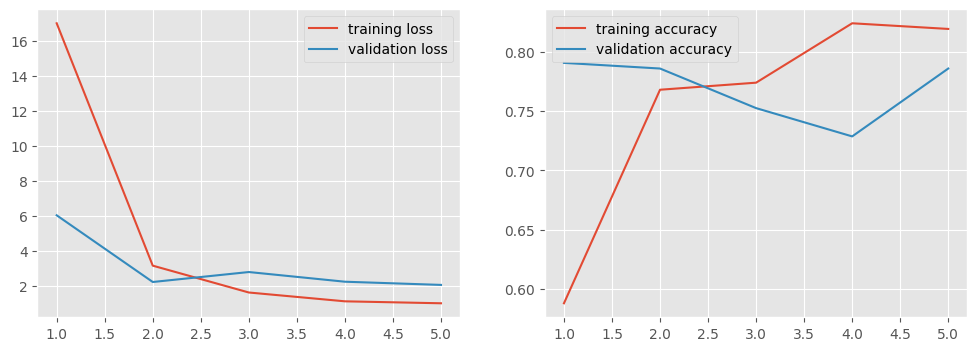

In [23]:
n_epochs = 5

fig, ax = plt.subplots(1,2, figsize=(12,4))

fig_range = np.arange(1, n_epochs+1)

sns.lineplot(x=fig_range, y=h.history['loss'], ax=ax[0], label='training loss')
sns.lineplot(x=fig_range, y=h.history['val_loss'], ax=ax[0], label='validation loss')

sns.lineplot(x=fig_range, y=h.history['accuracy'], ax=ax[1], label='training accuracy')
sns.lineplot(x=fig_range, y=h.history['val_accuracy'], ax=ax[1], label='validation accuracy')

plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred = [np.argmax(y) for y in y_pred]
y_pred = np.array(y_pred)

y_t = [np.argmax(y) for y in y_test]
y_t = np.array(y_t)

conf_mat = confusion_matrix(y_t, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step


In [25]:
y_pred

array([0, 5, 0, 2, 5, 6, 3, 0, 4, 0, 4, 2, 1, 6, 2, 2, 0, 4, 4, 4, 1, 1,
       3, 3, 6, 1, 2, 6, 5, 2, 4, 2, 3, 6, 0, 6, 1, 3, 3, 0, 4, 0, 6, 0,
       3, 6, 5, 3, 6, 6, 4, 2, 4, 2, 5, 0, 2, 0, 6, 1, 3, 3, 1, 3, 6, 5,
       1, 2, 2, 6, 0, 5, 0, 2, 2, 0, 4, 5, 3, 5, 0, 2, 4, 6, 3, 3, 1, 3,
       1, 0, 1, 0, 1, 5, 6, 1, 2, 4, 0, 4, 0, 1, 2, 4, 6, 5, 2, 4, 6, 5,
       0, 0, 2, 0, 1, 0, 0, 5, 2, 3, 1, 6, 4, 5, 6, 1, 0, 5, 0, 3, 6, 5,
       5, 6, 2, 3, 6, 2, 6, 6, 6, 2, 4, 4, 6, 5, 5, 4, 6, 4, 0, 2, 3, 1,
       5, 2, 6, 0, 0, 3, 4, 4, 1, 2, 3, 4, 6, 2, 3, 0, 1, 1, 2, 5, 2, 2,
       1, 1, 2, 3, 1, 0, 0, 6, 3, 1, 6, 1, 0, 2, 1, 5, 2, 1, 5, 2, 0, 1,
       1, 2, 5, 3, 2, 3, 3, 4, 0, 0, 5, 2])

In [26]:
print(classification_report(y_t, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70        30
           1       0.73      0.73      0.73        30
           2       0.76      0.93      0.84        30
           3       0.67      0.60      0.63        30
           4       0.92      0.73      0.81        30
           5       0.92      0.77      0.84        30
           6       0.94      0.97      0.95        30

    accuracy                           0.79       210
   macro avg       0.80      0.79      0.79       210
weighted avg       0.80      0.79      0.79       210



Text(0.5, 1.0, 'Confusion matrix of the predictions')

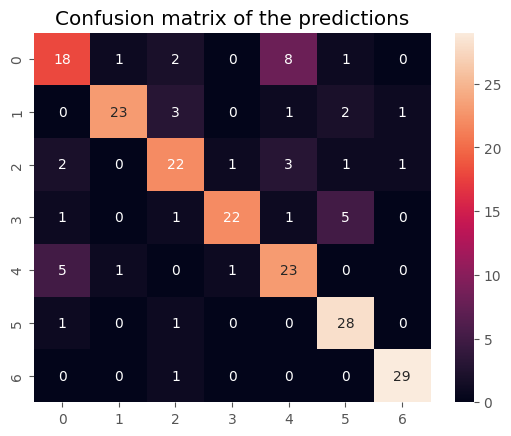

In [41]:
y_p = [reverse_dic[y] for y in y_pred]
y_t2 = [reverse_dic[y] for y in y_t]

conf_mat = confusion_matrix(y_t2, y_p)


sns.heatmap(conf_mat, annot=True, fmt=".0f")
plt.title("Confusion matrix of the predictions")
#plt.yticks(ticks=range(7), labels=list(items_dic_code));